In [2]:
triton = 1
# LOADS

import os, glob, time, math
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt, matplotlib.animation as animation, matplotlib.font_manager as fmg, matplotlib.colors as mpl_colors, matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import Ellipse
import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider
from scipy import ndimage, interpolate, integrate, spatial, optimize
from skimage.morphology import medial_axis, skeletonize, thin
from skimage import draw
import networkx as nx
import sympy as sp
import seaborn as sns
from shapely.geometry import LineString, Polygon

cTW = [(0, 0, 0, 0), (1, 1, 1, 1)]

# custom
colors = [#(0, 0, 0),   # black
          (.1, .1, .9),   # blue
          (.2, .8, 0),   # green
          (.8, .8, 0),   # yellow
          (.9, 0.4, 0), # orange
          (.9, 0, 0),   # red
          (.6, 0, .6)]#,   # pink
# sns based
colors = sns.color_palette("husl", 11)[-4::-1]

          #(1, 1, 1)]   # white
# Create the colormap
cmapTW = mpl_colors.ListedColormap(colors)
cmap = mpl_colors.LinearSegmentedColormap.from_list('my_colormap', list(colors))

#%matplotlib widget
%matplotlib inline
dpi = 300

if triton == 1:
    dir_path = r'/scratch/work/silvap1/temp' # CHANGE THIS FOLDER
    root = r'/scratch/work/silvap1'
    fsd = sorted(glob.glob(root + "/*mat_3d.npy"))
else:
    dir_path = r'\\home.org.aalto.fi\silvap1\data\Desktop\zahra\230414\temp' # CHANGE THIS FOLDER
    root = r'\\home.org.aalto.fi\silvap1\data\Desktop\zahra\230414'
    fsd = sorted(glob.glob(root + "\\*mat_3d.npy"))
fs = [f[-24:-11] for f in fsd]

In [3]:
fg_color = 'black'
def clean_directory(dir_path):
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path} due to {e}")

    while os.listdir(dir_path):
        time.sleep(10)
        
def adjust_endpoint(graph, endpoint, medial):
    row, col = endpoint
    neighbors = get_adjacent_nodes(endpoint, medial.shape)

    for neighbor in neighbors:
        if medial[neighbor] and neighbor not in graph.neighbors(endpoint):
            new_endpoint = ((row + neighbor[0]) // 2, (col + neighbor[1]) // 2)
            graph.add_edge(endpoint, new_endpoint)
            graph.remove_edge(endpoint, next(iter(graph.neighbors(endpoint))))
            break
            
def dfs(graph, node, visited, path):
    visited[node] = True
    path.append(node)
    longest_path = path.copy()

    for neighbor in graph.neighbors(node):
        if not visited[neighbor]:
            current_path = dfs(graph, neighbor, visited, path)
            if len(current_path) > len(longest_path):
                longest_path = current_path

    visited[node] = False
    path.pop()
    return longest_path         

def save_img(k):
    plot_scn()
    if triton == 1: plt.savefig(dir_path + '/' + str(k+1).zfill(3)+'.png', dpi=dpi, bbox_inches='tight',pad_inches=0)
    else: plt.savefig(dir_path + '\\' + str(k+1).zfill(3)+'.png', dpi=dpi, bbox_inches='tight',pad_inches=0)
    plt.close('all')

cmap = mpl.colormaps.get_cmap('turbo').copy()
def plot_scn():
    fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
    im = ax.imshow(mat, cmap=cmap, vmin = 20, vmax = 90)
    cmap.set_under('white') # SET color below vmin
    cmap.set_over('white')  # SET color over vmax
    poly = patches.Polygon(np.array(cont).reshape(-1, 2), linewidth=1, edgecolor='white', facecolor='none',alpha=0.5)
    ax.add_patch(poly)
    
    ax.plot(ys,xs,'w--',linewidth = 2, alpha=0.5)
    
    cb = fig.colorbar(im, ax=ax, pad=0.0, aspect=10, shrink=0.67)
    ax.axis('off')  
    font = fmg.FontProperties(size=14)
    for text in cb.ax.get_yticklabels():
        text.set_font_properties(font)
        text.set_color(fg_color)
    cb.outline.set_edgecolor(fg_color)
    cb.ax.yaxis.set_tick_params(color=fg_color)
    
    plt.xlim(0,xmax)
    plt.ylim(ymax,0)

def plot_scn2():
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(mat, cmap=cmap, vmin = 20, vmax = 100)
    cmap.set_under('black') # SET color below vmin
    cmap.set_over('white')  # SET color over vmax
    ellipse_patch1 = Ellipse(xy=ellipse1[0], width=ellipse1[1][0], height=ellipse1[1][1], angle=ellipse1[2], edgecolor='red', fill=False, linewidth=1, alpha=0.3)
    ax.add_patch(ellipse_patch1)
    ellipse_patch2 = Ellipse(xy=ellipse2[0], width=ellipse2[1][0], height=ellipse2[1][1], angle=ellipse2[2], edgecolor='red', fill=False, linewidth=1, alpha=0.3)
    ax.add_patch(ellipse_patch2)
    
def get_adjacent_nodes(node, shape):
    adjacent_nodes = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            r, c = node[0] + i, node[1] + j
            if r >= 0 and r < shape[0] and c >= 0 and c < shape[1]:
                adjacent_nodes.append((r, c))
    return adjacent_nodes

def adjust_rect_angle(rect):
    center, size, angle = rect
    width, height = size
    if (width < height):
        width, height = height, width
        angle += 90
    return (center, (width, height), angle)

def spline_derivative(t):
    h = 1
    return (spline(t + h) - spline(t - h)) / (2 * h)

# Define the function to compute the arc length integrand
def arc_length_integrand(t):
    return np.sqrt(1 + spline_derivative(t)**2)

def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1.flatten()
    x3, y3, x4, y4 = line2.flatten()

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    if denom == 0:
        return None

    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

    if 0 <= t <= 1 and 0 <= u <= 1:
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        return np.array([x, y])

    return None

def rdp(points, epsilon):
    """
    Implementation of the Ramer-Douglas-Peucker algorithm to simplify a polyline.
    """
    dmax = 0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax > epsilon:
        results1 = rdp(points[:index+1], epsilon)
        results2 = rdp(points[index:], epsilon)
        results1.extend(results2[1:])
        return results1
    else:
        return [points[0], points[-1]]

def point_line_distance(point, line_start, line_end):
    """
    Compute the distance between a point and a line defined by two points.
    """
    return np.linalg.norm(np.cross(line_end - line_start, line_start - point))/np.linalg.norm(line_end - line_start)

def angles_with_y_axis(polygon):
    edges = [np.linalg.norm(polygon[i] - polygon[(i+1)%4]) for i in range(4)]
    idx1, idx2 = np.argsort(edges)[-2:]
    vec1, vec2 = polygon[idx1] - polygon[idx1-1], polygon[idx2] - polygon[idx2-1]

    angle1 = np.degrees(np.arccos(np.dot(vec1, np.array([0, 1])) / np.linalg.norm(vec1)))
    angle2 = np.degrees(np.arccos(np.dot(vec2, np.array([0, 1])) / np.linalg.norm(vec2)))

    return angle1, angle2

def find_closest_point(spline, outside_point):
    # Evaluate the spline function to get the y-coordinate values
    spline_y = spline(outside_point[0])

    # Create a line segment connecting the outside point and the spline point
    line_segment = np.array([outside_point[0], spline_y]) - outside_point

    # Calculate the closest point on the spline
    closest_point = outside_point + line_segment

    return closest_point

In [102]:
draws = 1
er1 = 7
er2 = 21
crad1 = 30
crad2 = 40

for c in range(13, 14):
    if c < 10:
        wd, hg, xi, yi = 320, 300, 0, 20
    if c > 11:
        wd, hg, xi, yi = 320, 320, 0, 0
 
    c0 = 0
    t0 = 0
    c1 = 104
    ymax = hg+20*2
    xmax = wd
    cut = 0
    
    if c == 10:
        er1 = 2
        wd, hg, xi, yi = 240, 350, 0, 50 # 10
        ymax = hg+20*2
        xmax = wd
        x0, y0 = xmax/2+27, ymax-28
        r0 = 8
        cut = 0
    elif c == 11:
        er1 = 2
        wd, hg, xi, yi = 240, 350, 0, 50 # 10
        ymax = hg+20*2
        xmax = wd
        x0, y0 = xmax/2+50, ymax-30
        r0 = 8
        cut = 0
    
    matload = np.load(root + '/' + fs[c] + '_mat_3d.npy')
    t = np.load(root + '/' + fs[c] + '_time_3d.npy')
    h_len = np.zeros(len(matload))
    angle_1 = np.zeros(len(matload))
    angle_2 = np.zeros(len(matload))
    angle_1spl = np.zeros(len(matload))
    angle_2spl = np.zeros(len(matload))
    tempMAX = np.zeros(len(matload))
    for k in range(len(matload)):#range(0,c1+1):#
        
        # load and crop image
        mat2 = matload[k, yi:(yi+hg), xi:(xi+wd)]
        tempMAX[k] = np.amax(mat2)  
        mat = np.vstack((np.zeros((20, mat2.shape[1])), mat2, np.zeros((20, mat2.shape[1])))).astype(np.uint8)
        M0 = np.where(mat < 20, 0, mat)
        
        # Morphological operation
        ero1 = ndimage.binary_erosion(M0, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*er1, er1)), iterations=1).astype(mat.dtype)
        dil1 = ndimage.binary_dilation(ero1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*er1, er1)), iterations=1).astype(mat.dtype)
        dil2 = ndimage.binary_dilation(dil1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (er2, er2)), iterations=2).astype(mat.dtype)
        M = ndimage.binary_erosion(dil2, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (er2, er2)), iterations=2).astype(mat.dtype)
        _, binary_image = cv2.threshold(M, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Create skeleton and select the longest path and select the edges
        skeleton = skeletonize(binary_image / 255, method='lee').astype(np.uint8)
        # Create a graph from the skeleton
        graph = nx.Graph()
        for index in np.ndindex(skeleton.shape):
            if skeleton[index]:
                graph.add_node(index) 
        for node in graph.nodes:
            for neighbor in get_adjacent_nodes(node, skeleton.shape):
                if skeleton[neighbor]:
                    graph.add_edge(node, neighbor)
        # Find the endpoints and adjust them to be at the center of the two adjacent corner edges
        endpoints = [node for node, degree in graph.degree if degree == 1]
        for endpoint in endpoints:
            adjust_endpoint(graph, endpoint, skeleton)
        # Find the longest path in the graph 
        start_node = next(iter(graph.nodes))
        visited = {node: False for node in graph.nodes}
        longest_path = dfs(graph, start_node, visited, [])
        # Create a new image with only the longest path 
        longest_path_image = np.zeros_like(skeleton)
        for node in longest_path:
            longest_path_image[node] = 1
        # Find the two ends of the longest path
        end1, end2 = longest_path[0], longest_path[-1]
              
        # Create masks for the two circles
        circle1_mask = np.zeros_like(M, dtype=bool)
        circle2_mask = np.zeros_like(M, dtype=bool)
        rr1, cc1 = draw.disk((end1[0], end1[1]), crad1)
        rr2, cc2 = draw.disk((end2[0], end2[1]), crad2)
        circle1_mask[rr1.clip(0, M.shape[0] - 1), cc1.clip(0, M.shape[1] - 1)] = True
        circle2_mask[rr2.clip(0, M.shape[0] - 1), cc2.clip(0, M.shape[1] - 1)] = True
        mask1 = circle1_mask
        mask2 = circle2_mask
        
        # Find contours
        cont, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cont1, hierarchy1 = cv2.findContours(np.logical_and(binary_image,mask1).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cont2, hierarchy2 = cv2.findContours(np.logical_and(binary_image,mask2).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)    
        
        # Extract the contour points inside each circle (with swapped coordinates)
        contour1_points = max(cont1, key=cv2.contourArea)
        contour2_points = max(cont2, key=cv2.contourArea)
        
        # Fit rectangles to the contour sections
        rect1 = cv2.minAreaRect(contour1_points) 
        rect2 = cv2.minAreaRect(contour2_points)
        
        # Adjust the angle and dimensions of the rectangles
        rect1 = adjust_rect_angle(rect1)
        rect2 = adjust_rect_angle(rect2)
        
        box1 = cv2.boxPoints(rect1)
        box1 = np.intp(box1)
        box2 = cv2.boxPoints(rect2)
        box2 = np.intp
        
        # Calculation of values
        average_width = np.mean([rect1[1][1],rect2[1][1]])
        hh1 = rect1[0][0]/2 # half-height rectangle 1
        hh2 = rect2[0][0]/2
        
        sigma2 = 10
        skel = [(float(a[0]), float(a[1])) for a in longest_path]
        lp = ndimage.gaussian_filter1d(skel[cut:], sigma2, axis=0)
        
        # Evaluate the spline's derivative
        ang1, ang2 = (rect1[2]*np.pi/180, rect2[2]*np.pi/180)
        hip1, hip2 = (rect1[1][0]/2, rect2[1][0]/2)

        spline = interpolate.interp1d(lp[:,0], lp[:,1], kind='quadratic', fill_value="extrapolate")
        xd = np.linspace(0, ymax, 1000)
        yd = spline(xd)
        spl_points = np.column_stack((yd, xd))
        spl_linestring = LineString(spl_points)
        cont = np.array(max(cont, key=cv2.contourArea)).reshape(-1, 2)
        contour_polygon = Polygon(cont)  # Create a Polygon object from contour points
        contour_linestring = LineString(cont)

        intersection_points = spl_linestring.intersection(contour_polygon.boundary)
        
        # Calculate the arclength
        qa, qb = intersection_points.bounds[1:4:2]  
        if c > 9 and c < 12:
            # Create ROI to follow
            circle_roi = np.zeros_like(M, dtype=bool)
            rrroi, ccroi = draw.disk((y0, x0), r0)
            circle_roi[rrroi.clip(0, M.shape[0] - 1), ccroi.clip(0, M.shape[1] - 1)] = True
            mroi = circle_roi
            cont3, hierarchy3 = cv2.findContours(np.logical_and(M0,mroi).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)    
            contour3_points = max(cont3, key=cv2.contourArea) 
        
            ellipse3 = cv2.fitEllipse(contour3_points)
            ce0, ax0, _ = ellipse3
            dx, dy = x0-ce0[0]+r0-2, y0-ce0[1]
            x0, y0 = ce0[0]+ax0[0], ce0[1]-dy+6
            qc = find_closest_point(spline, [ce0[1],ce0[0]])
            h_len[k], _ = integrate.quad(arc_length_integrand, qa, qc[0])
            xs = np.linspace(qa,qc[0],100)
        else:
            h_len[k], _ = integrate.quad(arc_length_integrand, qa, qb)
            xs = np.linspace(qa,qb,100)
            
        ys = spline(xs)

        angle_1[k] = rect1[2]
        angle_2[k] = rect2[2]
        ellipse1 = cv2.fitEllipse(contour1_points)
        ellipse2 = cv2.fitEllipse(contour2_points)
        _, _, angle_1spl[k] = ellipse1
        _, _, angle_2spl[k] = ellipse2
        
        if draws == 1 and int(t[k]) > t0:
            dvid = int(t[k]-t0)
            t0 = int(t[k])
            if dvid > 1: print('Repeated', dvid)
            for l in range(dvid):
                save_img(c0)
                c0 += 1
            
    
    print(fs[c])
    plt.close('all')
    if draws == 1: 
        np.save(root + '/' + fs[c] + '_measure.npy', [h_len, angle_1, angle_2, angle_1spl, angle_2spl, tempMAX])
        video_name = 'video_v3_' + fs[c] + '.avi'
        images = sorted([img for img in os.listdir(dir_path) if img.endswith(".png")])
        frame = cv2.imread(os.path.join(dir_path, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10.0, (width,height))

        for l in range(c0):
            video.write(cv2.imread(os.path.join(dir_path, images[l])))

        cv2.destroyAllWindows()
        video.release()    

/tmp/ipykernel_27830/716370972.py:161: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  h_len[k], _ = integrate.quad(arc_length_integrand, qa, qb)


230414_123244


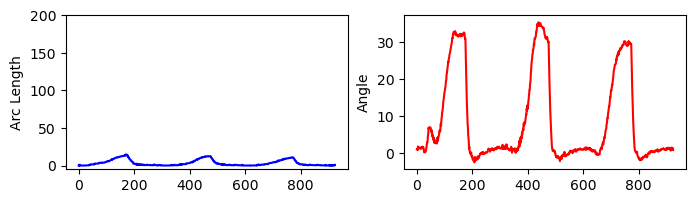

In [103]:
#### Plot the results
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
y = np.abs(h_len-h_len[0])
ax[0].plot(y,'b')
ax[0].set_ylabel('Arc Length')
ax[0].set_ylim((-5,200))

y2 = angle_1spl
y2[y2>90] -= 180
y3 = angle_2spl
y3[y3>90] -= 180

ax[1].plot(y3-y2,'r')
ax[1].set_ylabel('Angle');

In [98]:
# Save data file
np.save(root + '/' + fs[c] + '_measure.npy', [h_len, angle_1, angle_2, angle_1spl, angle_2spl, tempMAX])